In [1]:
# Spark libs
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark import SQLContext

# Others
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

# Graphs libs
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_dt

In [2]:
OBV_i = True
CCI_i = True
RSI_i = False
MACD_i = True
ManualSplit = True
Date_Convert = True

DEBUG  = True

In [3]:
def RSI(dataframe, window_length, avg_type, column='Close'):
    data = dataframe.toPandas()
    # Get just the close
    close = data['Close']
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous
    # row to calculate the differences
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    if avg_type == "EWMA":
        roll_up = up.ewm(span=window_length, min_periods=window_length).mean()
        roll_down = down.abs().ewm(
            span=window_length, min_periods=window_length).mean()
    elif avg_type == "SMA":
        roll_up = pd.rolling_mean(up, window_length)
        roll_down = pd.rolling_mean(down.abs(), window_length)
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    from pyspark.sql.types import FloatType
    temp_df = spark.createDataFrame(data=RSI, schema=FloatType()).fillna(0)
    from pyspark.sql.functions import monotonically_increasing_id
    df1 = temp_df.repartition(1).select("*").withColumn(
        "id", monotonically_increasing_id())
    df1 = df1.withColumnRenamed('value', 'RSI')
    df2 = converted_df.repartition(1).select("*").withColumn(
        "id", monotonically_increasing_id())
    joined_df = df1.join(df2, 'id')
    joined_df = joined_df.sort(joined_df.Date.asc())
    return joined_df.drop('id')

In [4]:
# Commodity Channel Index
def CCI(spark_df, ndays):
    data = spark_df.toPandas()
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    CCI = pd.Series(
        (TP - pd.rolling_mean(TP, ndays)) /
        (0.015 * pd.rolling_std(TP, ndays)),
        name='CCI')
    data = data.join(CCI)
    result_df = spark.createDataFrame(data)
    return result_df

In [5]:
# Spark context simple configuration
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()
path_to_csv = "./Datasets/Orlen.csv"

fresh_df = spark.read.csv(path_to_csv, header=True, inferSchema=True)
df_cleared = fresh_df.drop("Adj Close")

if DEBUG:
    df_cleared.show()

df_lag = df_cleared.withColumn('prev_day_price',
                               func.lag(df_cleared['Close']).over(
                                   Window.orderBy("Date")))
# Previous day price
df_with_prev_day_price = df_lag.withColumn(
    'Daily return', (df_lag['Close'] - df_lag['prev_day_price']))

df_profit = df_with_prev_day_price.withColumn(
    'Signal',
    (F.when(df_with_prev_day_price["Daily return"] < 0, 0).otherwise(1)))

df_lag = df_profit.withColumn('Signal',
                              func.lag(df_profit['Signal'], count=-1).over(
                                  Window.orderBy("Date")))
if DEBUG:
    df_lag.show()

final_df = df_profit.where(df_profit["Daily return"].isNotNull())

final_df = final_df.drop("prev_day_price").withColumnRenamed(
    existing="Daily return", new="Daily return")

#Conversion to desired typesf
converted_df = final_df.select(
    final_df["Date"].cast("Date"), final_df["Open"].cast("float"),
    final_df["High"].cast("float"), final_df["Volume"].cast("int"),
    final_df["Low"].cast("float"), final_df["Close"].cast("float"),
    final_df["Daily return"].cast("float"), final_df["Signal"].cast("int"))

+-------------------+--------+--------+--------+--------+------+
|               Date|    Open|    High|     Low|   Close|Volume|
+-------------------+--------+--------+--------+--------+------+
|2012-05-25 00:00:00|7.706000|7.706000|7.706000|7.706000|     0|
|2012-05-29 00:00:00|7.802000|7.809000|7.802000|7.809000|     0|
|2012-05-30 00:00:00|7.950000|7.950000|7.782000|7.782000|    10|
|2012-05-31 00:00:00|7.688000|7.688000|7.688000|7.688000|     0|
|2012-06-01 00:00:00|7.526000|7.526000|7.459000|7.459000|   300|
|2012-06-04 00:00:00|7.328000|7.328000|7.328000|7.328000|     0|
|2012-06-05 00:00:00|7.514000|7.514000|7.514000|7.514000|     0|
|2012-06-06 00:00:00|7.317000|7.317000|7.317000|7.317000|     0|
|2012-06-08 00:00:00|7.502000|7.569000|7.502000|7.569000|     0|
|2012-06-11 00:00:00|7.701000|7.701000|7.701000|7.701000|     0|
|2012-06-12 00:00:00|7.671000|7.671000|7.671000|7.671000|     0|
|2012-06-13 00:00:00|7.935000|7.935000|7.935000|7.935000|     0|
|2012-06-14 00:00:00|7.97

In [6]:
#Columns without Date
# converted_df = converted_df.select(
#     [col(c).cast('float') for c in converted_df.columns if c. not in {'Date'}])
# Date column!
df_date = converted_df.select(converted_df.Date)

if DEBUG:
    df_date.show()

#Convert date to splitted format
if Date_Convert:
    split_col = pyspark.sql.functions.split(converted_df['Date'], '-')
    converted_df = converted_df.withColumn('Year',
                                           split_col.getItem(0).cast('int'))
    converted_df = converted_df.withColumn('Month',
                                           split_col.getItem(1).cast('int'))
    converted_df = converted_df.withColumn('Day',
                                           split_col.getItem(2).cast('int'))
    if DEBUG:
        converted_df.show()

converted_df = converted_df.drop("Date")

+----------+
|      Date|
+----------+
|2012-05-29|
|2012-05-30|
|2012-05-31|
|2012-06-01|
|2012-06-04|
|2012-06-05|
|2012-06-06|
|2012-06-08|
|2012-06-11|
|2012-06-12|
|2012-06-13|
|2012-06-14|
|2012-06-15|
|2012-06-18|
|2012-06-19|
|2012-06-20|
|2012-06-21|
|2012-06-22|
|2012-06-25|
|2012-06-26|
+----------+
only showing top 20 rows

+----------+-----+-----+------+-----+-----+------------+------+----+-----+---+
|      Date| Open| High|Volume|  Low|Close|Daily return|Signal|Year|Month|Day|
+----------+-----+-----+------+-----+-----+------------+------+----+-----+---+
|2012-05-29|7.802|7.809|     0|7.802|7.809|       0.103|     1|2012|    5| 29|
|2012-05-30| 7.95| 7.95|    10|7.782|7.782|      -0.027|     0|2012|    5| 30|
|2012-05-31|7.688|7.688|     0|7.688|7.688|      -0.094|     0|2012|    5| 31|
|2012-06-01|7.526|7.526|   300|7.459|7.459|      -0.229|     0|2012|    6|  1|
|2012-06-04|7.328|7.328|     0|7.328|7.328|      -0.131|     0|2012|    6|  4|
|2012-06-05|7.514|7.514|     0

In [7]:
# Moving average convergence divergence
def MACD(dataframe, nfast=12, nslow=24, column = 'Close'):
    data = dataframe.toPandas()
    # Get just the close
    price = data[column]
    # Get the difference in price from previous step
    emaslow = pd.ewma(price, span=nslow, min_periods=1)
    emafast = pd.ewma(price, span=nfast, min_periods=1)
#     MACD = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    MACD = pd.DataFrame({'MACD': emafast-emaslow})
    data = data.join(MACD)
    result_df = spark.createDataFrame(data)
    if DEBUG:
        result_df.show()
    return result_df

In [8]:
if MACD_i:
    converted_df = MACD(converted_df)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

/home/zapo/Documents/SparkDev/spark_env/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=1,adjust=True,ignore_na=False,span=24).mean()
  import sys
/home/zapo/Documents/SparkDev/spark_env/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=1,adjust=True,ignore_na=False,span=12).mean()
  


+-----------------+-----------------+------+------------------+------------------+--------------------+------+----+-----+---+--------------------+
|             Open|             High|Volume|               Low|             Close|        Daily return|Signal|Year|Month|Day|                MACD|
+-----------------+-----------------+------+------------------+------------------+--------------------+------+----+-----+---+--------------------+
|7.802000045776367|7.809000015258789|     0| 7.802000045776367| 7.809000015258789| 0.10300000011920929|     1|2012|    5| 29|                 0.0|
|7.949999809265137|7.949999809265137|    10|7.7820000648498535|7.7820000648498535|-0.02700000070035...|     0|2012|    5| 30| -5.6249896685312E-4|
|7.688000202178955|7.688000202178955|     0| 7.688000202178955| 7.688000202178955|-0.09399999678134918|     0|2012|    5| 31|-0.00342484749719...|
|7.526000022888184|7.526000022888184|   300| 7.459000110626221| 7.459000110626221| -0.2290000021457672|     0|2012|   

In [9]:
if CCI_i:
    converted_df = CCI(converted_df, 14)
    converted_df = converted_df.select(
        [col(c).cast('float') for c in converted_df.columns])
    if DEBUG:
        converted_df.show()

/home/zapo/Documents/SparkDev/spark_env/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  
/home/zapo/Documents/SparkDev/spark_env/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).std()
  import sys


+-----+-----+------+-----+-----+------------+------+------+-----+----+-------------+---------+
| Open| High|Volume|  Low|Close|Daily return|Signal|  Year|Month| Day|         MACD|      CCI|
+-----+-----+------+-----+-----+------------+------+------+-----+----+-------------+---------+
|7.802|7.809|   0.0|7.802|7.809|       0.103|   1.0|2012.0|  5.0|29.0|          0.0|      NaN|
| 7.95| 7.95|  10.0|7.782|7.782|      -0.027|   0.0|2012.0|  5.0|30.0|  -5.62499E-4|      NaN|
|7.688|7.688|   0.0|7.688|7.688|      -0.094|   0.0|2012.0|  5.0|31.0|-0.0034248475|      NaN|
|7.526|7.526| 300.0|7.459|7.459|      -0.229|   0.0|2012.0|  6.0| 1.0| -0.012326616|      NaN|
|7.328|7.328|   0.0|7.328|7.328|      -0.131|   0.0|2012.0|  6.0| 4.0| -0.021733696|      NaN|
|7.514|7.514|   0.0|7.514|7.514|       0.186|   1.0|2012.0|  6.0| 5.0| -0.019541662|      NaN|
|7.317|7.317|   0.0|7.317|7.317|      -0.197|   0.0|2012.0|  6.0| 6.0|  -0.02610725|      NaN|
|7.502|7.569|   0.0|7.502|7.569|       0.252|   1.

In [10]:
# OBV indicator calculation
if OBV_i:
    temp_df = converted_df.toPandas()
    df_obv = spark.createDataFrame(
        temp_df.assign(OBV=(temp_df.Volume * (
            ~temp_df.Close.diff().le(0) * 2 - 1)).cumsum()))
    converted_df = df_obv.select(
        [col(c).cast('float') for c in df_obv.columns])
    if DEBUG:
        converted_df.show()

+-----+-----+------+-----+-----+------------+------+------+-----+----+-------------+---------+-------+
| Open| High|Volume|  Low|Close|Daily return|Signal|  Year|Month| Day|         MACD|      CCI|    OBV|
+-----+-----+------+-----+-----+------------+------+------+-----+----+-------------+---------+-------+
|7.802|7.809|   0.0|7.802|7.809|       0.103|   1.0|2012.0|  5.0|29.0|          0.0|      NaN|    0.0|
| 7.95| 7.95|  10.0|7.782|7.782|      -0.027|   0.0|2012.0|  5.0|30.0|  -5.62499E-4|      NaN|  -10.0|
|7.688|7.688|   0.0|7.688|7.688|      -0.094|   0.0|2012.0|  5.0|31.0|-0.0034248475|      NaN|  -10.0|
|7.526|7.526| 300.0|7.459|7.459|      -0.229|   0.0|2012.0|  6.0| 1.0| -0.012326616|      NaN| -310.0|
|7.328|7.328|   0.0|7.328|7.328|      -0.131|   0.0|2012.0|  6.0| 4.0| -0.021733696|      NaN| -310.0|
|7.514|7.514|   0.0|7.514|7.514|       0.186|   1.0|2012.0|  6.0| 5.0| -0.019541662|      NaN| -310.0|
|7.317|7.317|   0.0|7.317|7.317|      -0.197|   0.0|2012.0|  6.0| 6.0|  -

In [11]:
#RSI indicator calculaction
if RSI_i:
    converted_df = RSI(converted_df, 3, 'SMA')
    if DEBUG:
        converted_df.show()
        print(converted_df.count())

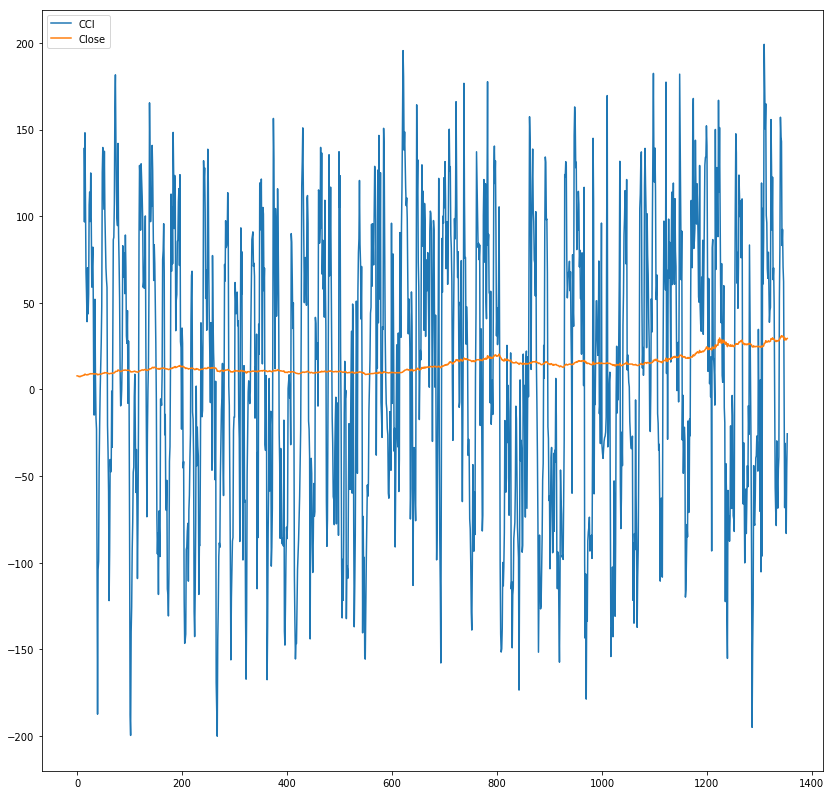

In [12]:
df_to_plot_dt = converted_df.select("CCI", 'Close').toPandas()
plt_dt.figure(figsize=(14, 14))
plt_dt.plot(df_to_plot_dt)
plt_dt.legend(df_to_plot_dt.columns)
plt_dt.show()

In [13]:
# Manuall split for training and validating data

if ManualSplit:
    dfp = converted_df.toPandas()

    dfp = np.array_split(dfp, 10)

    p0 = spark.createDataFrame(data=dfp[0])
    p1 = spark.createDataFrame(data=dfp[1])
    p2 = spark.createDataFrame(data=dfp[2])
    p3 = spark.createDataFrame(data=dfp[3])
    p4 = spark.createDataFrame(data=dfp[4])
    p5 = spark.createDataFrame(data=dfp[5])
    p6 = spark.createDataFrame(data=dfp[6])
    p7 = spark.createDataFrame(data=dfp[7])
    p8 = spark.createDataFrame(data=dfp[8])
    p9 = spark.createDataFrame(data=dfp[9])

    p_final = p0.union(p1).union(p2).union(p3).union(p4).union(p5).union(
        p6).union(p7).union(p8)
    train = p_final
    test = p9
    #     test = p9.head(10)
    #     test = spark.createDataFrame(test)
else:
    train, test = converted_df.randomSplit([0.9, 0.1])

print("We have %d training examples and %d test examples." % (train.count(),
                                                              test.count()))

# train.repartition(1).write.csv("train.csv")
# test.repartition(1).write.csv("test.csv")

We have 1219 training examples and 135 test examples.


In [14]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, VectorIndexer

featuresCols = converted_df.columns
featuresCols.remove('Signal')
featuresCols.remove('Daily return')

print(featuresCols)

# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")

# VectorIndexer:
# is used to index categorical predictors in a featuresCol column.
# Remember that featuresCol is a single column consisting of vectors (refer to featuresCol and labelCol).
# Each row is a vector which contains values from each predictors.

featureIndexer_rt = VectorIndexer(
    inputCol="rawFeatures",
    outputCol="features",
    maxCategories=len(featuresCols))

['Open', 'High', 'Volume', 'Low', 'Close', 'Year', 'Month', 'Day', 'MACD', 'CCI', 'OBV']


In [15]:
# Algorithm
from pyspark.ml.classification import RandomForestClassifier

rt = RandomForestClassifier(labelCol='Signal', featuresCol="features")

In [16]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
# In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
# and more trees in the ensemble (>100).

max_Depth_Range = list(range(14, 16))
maxTrees = list(range(25, 26))

paramGrid_rt = ParamGridBuilder() \
    .addGrid(rt.maxBins, max_Depth_Range) \
    .addGrid(rt.numTrees, maxTrees) \
    .addGrid(rt.maxMemoryInMB, [1500] ).build()

# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true
# labels with predictions.
evaluator_rt = MulticlassClassificationEvaluator(
    metricName="accuracy",
    labelCol=rt.getLabelCol(),
    predictionCol=rt.getPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
cv_rt = CrossValidator(
    estimator=rt,
    evaluator=evaluator_rt,
    estimatorParamMaps=paramGrid_rt,
    numFolds=3)

Precision on our test set: 0.622222
+----------+--------------------+
|prediction|        Daily return|
+----------+--------------------+
|       1.0|  0.3980009853839874|
|       1.0| -0.1300020068883896|
|       0.0| 0.06800100207328796|
|       1.0|   3.096000909805298|
|       1.0| -1.5379999876022339|
|       1.0|   2.594999074935913|
|       1.0| -0.9330000281333923|
|       1.0| -0.9729999899864197|
|       0.0| -1.0599989891052246|
|       1.0|  1.9879980087280273|
|       0.0| -1.8959989547729492|
|       0.0| 0.03400000184774399|
|       0.0|  0.6150000095367432|
|       1.0|   0.972000002861023|
|       0.0|  -1.273000955581665|
|       0.0|0.035002000629901886|
|       0.0| -1.1139999628067017|
|       1.0|  1.2489980459213257|
|       0.0|  -0.611998975276947|
|       0.0| -1.1119999885559082|
+----------+--------------------+
only showing top 20 rows



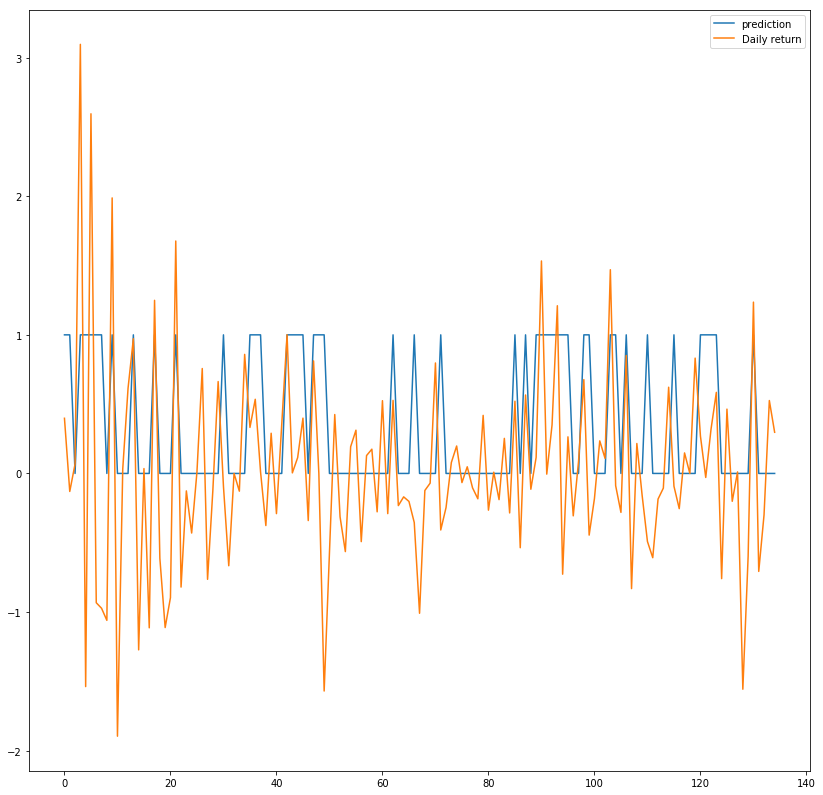

In [17]:
# Creating Final pipeline object
pipeline_rt = Pipeline(stages=[vectorAssembler_rt, featureIndexer_rt, cv_rt])

# FITTING!
pipelineModel_rt = pipeline_rt.fit(train)

# Making Predictions!
predictions_rt = pipelineModel_rt.transform(test)
# predictions_dt.show()

# Calculating metrics
precision = evaluator_rt.evaluate(predictions_rt)

print("Precision on our test set: %g" % precision)

df_to_plot_rt = predictions_rt.select('prediction', 'Daily return')

df_to_plot_rt.show()

import matplotlib.pyplot as plt_dt

df_to_plot_rt = df_to_plot_rt.toPandas()
plt_dt.figure(figsize=(14, 14))
plt_dt.plot(df_to_plot_rt)
plt_dt.legend(df_to_plot_rt.columns)
plt_dt.show()